In [1]:
import argparse
import treegp
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from sklearn.gaussian_process.kernels import Kernel
import os
import treecorr

# plotting things
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

plt.rcParams['font.size'] = 17
plt.rcParams['axes.labelsize'] = 17

def initSeeds():
    seeds = list(range(6,11))+[22,23,25,26,27]+list(range(30,40))
    seeds +=list(range(42,54))+list(range(55,61))+list(range(62,90))
    seeds += list(range(90,171))
    return seeds

def comp_2pcf_treecorr(x, y, k, bin_type='TwoD'):
    """calculate 2pcf for scalar k"""
    cat = treecorr.Catalog(x=x, y=y, k=k, w=None)
    kk = treecorr.KKCorrelation(min_sep=0, max_sep=0.15, nbins=17,
                                bin_type=bin_type, bin_slop=0)
    kk.process(cat)
    return kk.xi

def raw_moments(im, ordx=1, ordy=1):
    """calculate raw moment of image"""
    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    posX = posX-8
    posY = posY-8
    rmom = sum(sum(im*posX**ordx*posY**ordy))
    return rmom

def centroids(im):
    """find the centroids of the image"""
    M10 = raw_moments(im, ordx=1, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M01 = raw_moments(im, ordx=0, ordy=1)
    xbar = M10/M00
    ybar = M01/M00
    return xbar, ybar

def get_theta(g1, g2):
    """find angle from acrtan2 given x and y"""
    # this give theta in degrees
    phi = np.arctan2(g2,g1)*180/np.pi
    if g1*g2> 0:
        #first, quadrant
        if g1 > 0:
            phi = phi
        #third quadrant
        else: 
            phi = phi+360
    # second quadrant
    elif g1 < 0 and g2 > 0:
        phi = phi
    # fouth quadrant
    elif g1 > 0 and g2 < 0:
        phi = phi+360 
    theta = phi/2
    return theta

def get_orient(im):
    """calculate angle of image from moments"""
    xbar, ybar = centroids(im)
    M20 = raw_moments(im, ordx=2, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M02 = raw_moments(im, ordx=0, ordy=2)
    M11 = raw_moments(im, ordx=1, ordy=1)
    
    mu20p = M20/M00 - xbar**2
    mu02p = M02/M00 - ybar**2
    mu11p = M11/M00 - xbar*ybar
    
    #angle in degrees
    theta = get_theta(mu20p-mu02p,2*mu11p)
    return theta

def get_simData(seed, kind, R=1):
    """get simulation data from .pkl files"""
    
    # 3 kinds of data
    if kind == "psfws":
        d = pickle.load(open("..//runsims//sameheightPsfws//outh_psfws_"+str(seed)+".pkl", 'rb'))
    elif kind =="rand":
        d = pickle.load(open("..//runsims//sameheightRand//outh_rand_"+str(seed)+".pkl", 'rb'))
    elif kind=="randMatch":
        d = pickle.load(open("..//runsims//matchSpeedRand//outv_rand_"+str(seed)+".pkl", 'rb'))

    for key in d.keys():
        d[key] = np.array(d[key])
    (thx, thy, _, _, _, sigma, e1, e2, _, _, _) = tuple(d.values())
    d_sigma = sigma - np.mean(sigma)
    
    #option for circular data
    return thx, thy, d_sigma, e1, e2 

def circle(im):
    R = im.shape[0]/2
    posY, posX = np.indices(im.shape)
    posX = posX-8
    posY = np.flipud(posY)-8
    incircle = np.argwhere(np.hypot(posX,posY) > R)
    for ind in incircle:
        indX = ind[0]
        indY = ind[1]
        im[indX,indY] = 0
    return im

def get_angles(seeds, kind, circ=False, R=2):
    """calculate 2pcf and get angles of 2pcf"""
    #get angles of 2pcf
    theta_dsigma, theta_e1, theta_e2 = {}, {}, {}
    for seed in seeds:
        thx, thy, d_sigma, e1, e2 = get_simData(seed, kind, R)
        
        # compute 2pcf
        xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)
        xi_e1 = comp_2pcf_treecorr(thx, thy, e1)
        xi_e2 = comp_2pcf_treecorr(thx, thy, e2)
        
        if circ:
            xi_dsigma = circle(xi_dsigma)
            xi_e1 = circle(xi_e1)
            xi_e2 = circle(xi_e2)
            
        # compute angles
        theta_dsigma[seed] = get_orient(xi_dsigma)
        theta_e1[seed] = get_orient(xi_e1)
        theta_e2[seed] = get_orient(xi_e2)
    return theta_dsigma, theta_e1, theta_e2

def plothist(ax,para,clr, lbl=""):
    """plot histogram of para as points with poisson uncertainty"""
    y, bin_edges, _ = ax.hist(para, bins=25, histtype='step', color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color=clr, label=lbl)
    return ax

def dataAngles():
    seeds = initSeeds()
    
    theta_dsigmaP, theta_e1P, theta_e2P = get_angles(seeds, "psfws")
    theta_dsigmaR, theta_e1R, theta_e2R = get_angles(seeds, "rand")
    theta_dsigmaRM, theta_e1RM, theta_e2RM = get_angles(seeds, "randMatch")

    theta_dsigmaPC, theta_e1PC, theta_e2PC = get_angles(seeds, "psfws", circ=True)
    theta_dsigmaRC, theta_e1RC, theta_e2RC = get_angles(seeds, "rand", circ=True)
    theta_dsigmaRMC, theta_e1RMC, theta_e2RMC = get_angles(seeds, "randMatch", circ=True)
    
    paraP = [theta_dsigmaP.values(), theta_e1P.values(), theta_e2P.values()]
    paraR = [theta_dsigmaR.values(), theta_e1R.values(), theta_e2R.values()]
    paraPC = [theta_dsigmaPC.values(), theta_e1PC.values(), theta_e2PC.values()]
    paraRC = [theta_dsigmaRC.values(), theta_e1RC.values(), theta_e2RC.values()]
    paraRM = [theta_dsigmaRM.values(), theta_e1RM.values(), theta_e2RM.values()]
    paraRMC = [theta_dsigmaRMC.values(), theta_e1RMC.values(), theta_e2RMC.values()]
    return paraP, paraR, paraPC, paraRC, paraRM, paraRMC



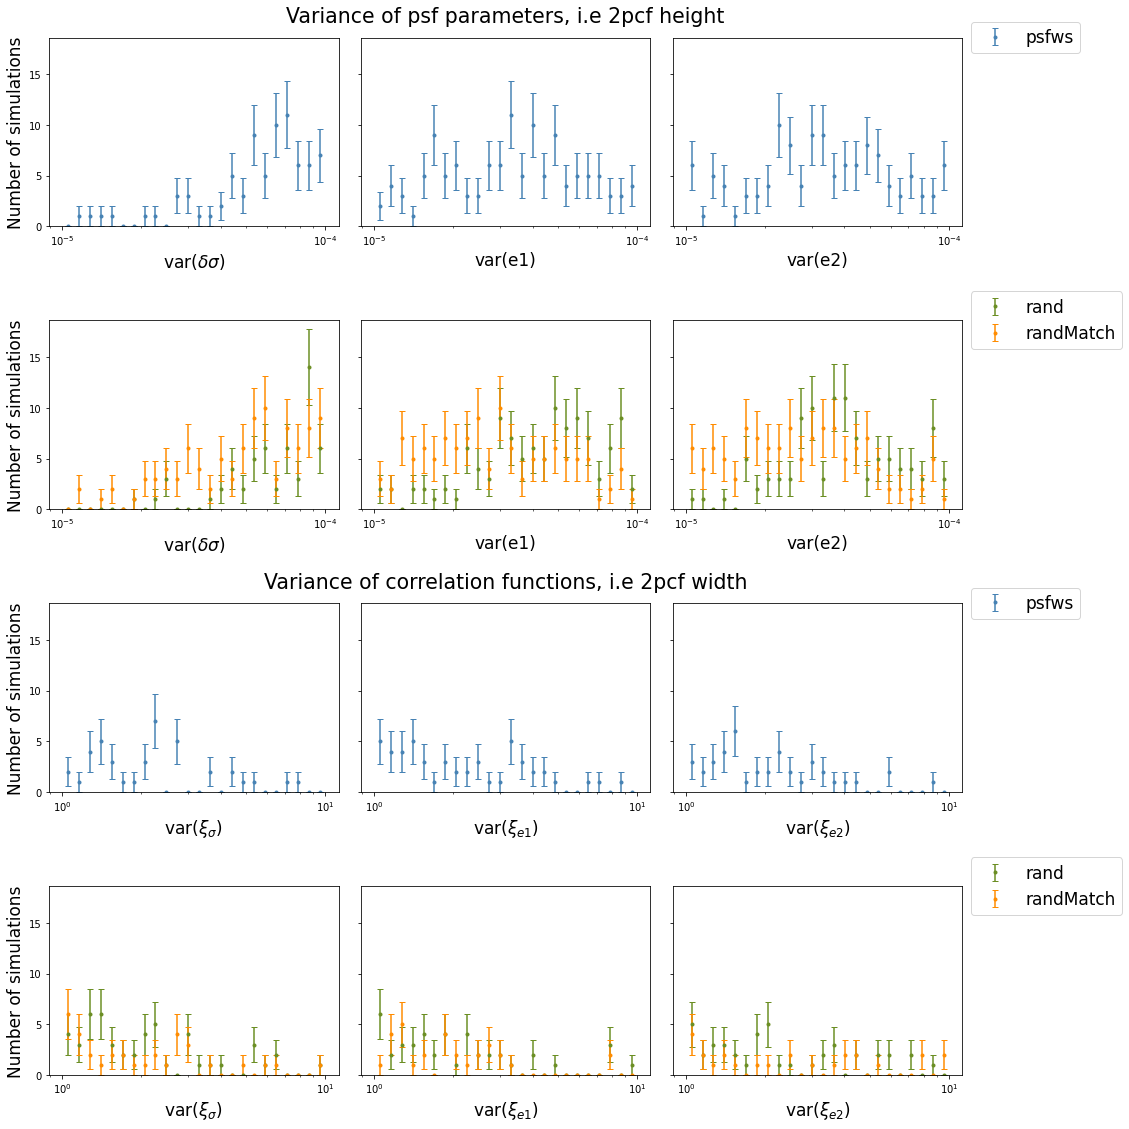

In [2]:
seeds = initSeeds()

def varPSF(seeds, kind, circ):
    varSigma, varE1, varE2= [], [], []
    for seed in seeds:
        _, _, d_sigma, e1, e2 = get_simData(seed, kind, circ)
        varSigma.append(np.var(d_sigma))
        varE1.append(np.var(e1))
        varE2.append(np.var(e2))
    return varSigma, varE1, varE2 


def secMomSum(seeds, kind, R=1):
    Sdsigma, Se1, Se2 = {}, {}, {}
    for seed in seeds:
        thx, thy, d_sigma, e1, e2 = get_simData(seed, kind,  R)
        # compute 2pcf
        xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)
        xi_e1 = comp_2pcf_treecorr(thx, thy, e1)
        xi_e2 = comp_2pcf_treecorr(thx, thy, e2)
        
        Sdsigma[seed] = raw_moments(xi_dsigma, ordx=2, ordy=0) + raw_moments(xi_dsigma, ordx=0, ordy=2)
        Se1[seed] = raw_moments(xi_e1, ordx=2, ordy=0) + raw_moments(xi_e1, ordx=0, ordy=2)
        Se2[seed] = raw_moments(xi_e2, ordx=2, ordy=0) + raw_moments(xi_e2, ordx=0, ordy=2)
    return Sdsigma, Se1, Se2

# psf para variances
varSigmaP, varE1P, varE2P = varPSF(seeds, "psfws", circ=False)
varSigmaR, varE1R, varE2R = varPSF(seeds, "rand", circ=False)
varSigmaRM, varE1RM, varE2RM = varPSF(seeds, "randMatch", circ=True)

# 2pcf 2nd moments sum
SdsigmaP, Se1P, Se2P = secMomSum(seeds, "psfws")
SdsigmaR, Se1R, Se2R = secMomSum(seeds, "rand")
SdsigmaRM, Se1RM, Se2RM = secMomSum(seeds, "randMatch")

def plothistL(ax, para, clr, binn, lbl=""):
    """plot histogram of para as points with poisson uncertainty"""
    y, bin_edges, _ = ax.hist(para, bins=binn, histtype='step', color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color=clr, label=lbl)
    return ax

#--------------formatting setup
fig,ax = plt.subplots(4,3,figsize=(16,16), sharey=True)
plt.rcParams['font.size'] = 17
plt.rcParams['axes.labelsize'] = 17
c = ["darksalmon", "olivedrab"]
l = ["rand", "randMatch"]


#----------------plot 2pcf heights
varPsfws = [varSigmaP, varE1P, varE2P]
varRand = [varSigmaR, varE1R, varE2R]
varRandMatch = [varSigmaRM, varE1RM, varE2RM]

[plothistL(ax[0,i], varPsfws[i], "steelblue", np.logspace(-5,-4, 25), "psfws") for i in range(3)]
[plothistL(ax[1,i], varRand[i], "olivedrab", np.logspace(-5,-4, 25), "rand") for i in range(3)]
[plothistL(ax[1,i], varRandMatch[i], "darkorange", np.logspace(-5,-4, 25), "randMatch") for i in range(3)]
      
    
#--------------plot 2pcf widths
momP = [[SdsigmaP, Se1P, Se2P][i].values() for i in range(3)]
momR = [[SdsigmaR, Se1R, Se2R][i].values() for i in range(3)]
momRM = [[SdsigmaRM, Se1RM, Se2RM][i].values() for i in range(3)]

[plothistL(ax[2,i], momP[i], "steelblue", np.logspace(0,1, 25), "psfws") for i in range(3)]
[plothistL(ax[3,i], momR[i], "olivedrab", np.logspace(0,1, 25), "rand") for i in range(3)]
[plothistL(ax[3,i], momRM[i], "darkorange", np.logspace(0,1, 25), "randMatch") for i in range(3)]
 

#--------------formatting
var_xlbls = ["var($\\delta\\sigma}$)", "var(e1)", "var(e2)"]        
mom_xlbls = ["var($\\xi_{\\sigma}$)", "var($\\xi_{e1}$)", "var($\\xi_{e2}$)"]

[[ax[j,i].set_xlabel(var_xlbls[i]) for i in range(3)] for j in [0,1]]
[[ax[j,i].set_xlabel(mom_xlbls[i]) for i in range(3)]  for j in[2,3]]     
[ax[i,0].set_ylabel("Number of simulations") for i in range(4)]

[[ax[j,i].set_xscale("log") for i in range(3)] for j in range(4)]
[ax[i,2].legend(loc='center left', bbox_to_anchor=(1, 1)) for i in [1,3]]
[ax[i,2].legend(loc='center left', bbox_to_anchor=(1, 1)) for i in [0,2]]

#[[ax[j,i].set_ylim(ymax=20) for i in range(3)] for j in range(2)]

ax[0,1].set_title("Variance of psf parameters, i.e 2pcf height", pad=15) 
ax[2,1].set_title("Variance of correlation functions, i.e 2pcf width", pad=15)

fig.tight_layout()